In [197]:
import sf_quant as sf
import sf_quant.data
from sf_quant.data.factors import load_factors, get_factor_names
from sf_quant.data import load_crsp_monthly, get_crsp_monthly_columns
from sf_quant.data import load_exposures, get_exposures_columns
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import polars as pl
from sklearn.linear_model import LinearRegression


In [198]:
# Load in daily factor data 

start = dt.date(2000,1,1)
end = dt.date(2020,1,1)

factors = get_factor_names(type = 'style')
daily = load_factors(start=start, end=end, factors=factors)
daily = daily.unpivot(index='date', variable_name='factor', value_name='ret')
daily = daily.to_pandas()
daily['ret'] = daily['ret'] / 100

daily

,date,factor,ret
0,2000-01-03,USSLOWL_BETA,0.002082
1,2000-01-04,USSLOWL_BETA,-0.006150
2,2000-01-05,USSLOWL_BETA,-0.002357
3,2000-01-06,USSLOWL_BETA,-0.003232
4,2000-01-07,USSLOWL_BETA,0.010328
...,...,...,...
80491,2019-12-24,USSLOWL_VALUE,-0.000262
80492,2019-12-26,USSLOWL_VALUE,0.000784
80493,2019-12-27,USSLOWL_VALUE,-0.000576
80494,2019-12-30,USSLOWL_VALUE,0.002228


In [199]:
# ensure date is datetime and sorted
daily['date'] = pd.to_datetime(daily['date'])
daily = daily.sort_values('date').reset_index(drop=True)


In [200]:
# make wide just cuz I like wide
df_wide = daily.pivot(index='date', columns='factor', values='ret')


In [201]:
# monthly cumulative returns per factor (at month-end)
monthly = (1 + df_wide).resample('M').prod() - 1
monthly.index.name = 'month_end'
monthly


/tmp/ipykernel_1492870/3692319501.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = (1 + df_wide).resample('M').prod() - 1


factor,USSLOWL_BETA,USSLOWL_DIVYILD,USSLOWL_EARNQLTY,USSLOWL_EARNYILD,USSLOWL_GROWTH,USSLOWL_LEVERAGE,USSLOWL_LIQUIDTY,USSLOWL_LTREVRSL,USSLOWL_MGMTQLTY,USSLOWL_MIDCAP,USSLOWL_MOMENTUM,USSLOWL_PROFIT,USSLOWL_PROSPECT,USSLOWL_RESVOL,USSLOWL_SIZE,USSLOWL_VALUE
month_end,,,,,,,,,,,,,,,,
2000-01-31,0.009330,0.000898,-0.004636,-0.024407,0.002257,-0.002422,-0.008666,0.008615,0.000927,-0.023803,-0.001674,-0.002242,0.008393,-0.002150,-0.014058,0.000361
2000-02-29,0.034641,0.008303,-0.001145,-0.008864,0.005712,-0.014273,-0.002514,0.001022,-0.016372,-0.003518,0.049200,-0.010310,0.002236,0.029201,-0.055315,-0.014402
2000-03-31,-0.028798,-0.015709,-0.003108,-0.001284,-0.008179,0.003979,0.003901,-0.010778,0.002618,0.014301,-0.034178,0.026600,0.020558,-0.045385,0.023530,-0.013844
2000-04-30,-0.024169,-0.000629,0.019096,0.030531,-0.033073,0.013417,-0.004206,-0.003047,-0.007046,0.012714,-0.003386,0.004516,0.013161,-0.034950,0.014114,-0.006272
2000-05-31,-0.014748,0.006795,0.008405,0.019679,-0.009774,0.001598,0.002710,0.004420,0.001444,0.022265,-0.014745,0.001590,0.010788,-0.018299,0.011624,-0.000379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-31,-0.032623,-0.005190,0.001684,-0.010869,0.004736,0.002550,-0.000506,-0.006838,0.000696,-0.005107,0.018684,0.002665,0.005110,-0.013063,0.009736,-0.007536
2019-09-30,0.004784,0.007020,0.006261,0.005795,-0.001292,0.004968,0.002450,0.010137,0.002291,-0.007671,-0.042215,-0.003169,-0.001954,-0.018434,0.000848,0.006780
2019-10-31,0.003682,-0.001036,-0.006769,-0.000676,-0.003024,0.001354,0.000489,-0.008504,0.001255,0.000600,0.008818,0.004720,0.002012,0.000294,0.002079,-0.000490


In [202]:
##################################
# BASIC SIGNALS (1 IF > MEDIAN, -1 IF < MEDIAN, 0 IF MEDIAN)
##################################


# Use previous-month returns to form signal at time t
monthly_lag = monthly.shift(1)   # index t contains returns from t-1

# cross-sectional median (for each row/month)
cs_median = monthly_lag.median(axis=1)

# signal: +1 if > median, -1 if < median, 0 if equal (NaNs propagate)
simple_signals = monthly_lag.gt(cs_median, axis=0).astype(int) - monthly_lag.lt(cs_median, axis=0).astype(int)

# Optional: fill NaN signals with 0 if you prefer neutral instead of NaN
# signals = signals.fillna(0)



In [203]:
###############################
# Z-SCORING SIGNALS 
###############################

# Use previous-month returns to form signal at time t
monthly_lag = monthly.shift(1)  # index t contains returns from t-1

# Cross-sectional mean and std (or median & MAD if you want robust)
cs_mean = monthly_lag.mean(axis=1)
cs_std = monthly_lag.std(axis=1)

# z-score across each row (month)
# subtract mean and divide by std
weighted_signals = (monthly_lag.sub(cs_mean, axis=0)).div(cs_std, axis=0)

# optional: cap extreme z-scores to avoid crazy leverage
weighted_signals = weighted_signals.clip(-3, 3)




In [204]:
def factor_strategy(sgnls, monthly):

    # Element-wise multiply signals by factor returns
    long_short_matrix = sgnls * monthly

    # For each month: sum of (signal * return) / number of active signals
    # (avoid dividing by zero if a month has no signals)
    strategy_monthly = long_short_matrix.sum(axis=1) / sgnls.abs().sum(axis=1)

    # Clean up NaNs
    strategy_monthly = strategy_monthly.dropna()
    strategy_cum = (1 + strategy_monthly).cumprod() - 1

    return strategy_monthly, strategy_cum

simple_strategy_monthly, simple_strategy_cum = factor_strategy(simple_signals, monthly)
zscore_strategy_monthly, zscore_strategy_cum = factor_strategy(weighted_signals, monthly)

In [205]:
def factor_performance(strat_monthly, strat_cum, name = "No name"):
    print(f"{name}\n")
    print(f"{name} Annualized mean return:", strat_monthly.mean() * 12)
    print(f"{name} Annualized volatility:", strat_monthly.std() * np.sqrt(12))
    print(f"{name} Sharpe ratio:", strat_monthly.mean() / strat_monthly.std() * np.sqrt(12))
    print(f"{name} Cumulative return:", strat_cum.iloc[-1])
    print(f"\n")

factor_performance(simple_strategy_monthly, simple_strategy_cum, name = "Simple")
factor_performance(zscore_strategy_monthly, zscore_strategy_cum, name = "Zscore")

Simple

Simple Annualized mean return: 0.004192202427885856
Simple Annualized volatility: 0.010577809801475541
Simple Sharpe ratio: 0.39632045825791534
Simple Cumulative return: 0.08586018696749664


Zscore

Zscore Annualized mean return: 0.005287287619931897
Zscore Annualized volatility: 0.02124388485317678
Zscore Sharpe ratio: 0.2488851571392905
Zscore Cumulative return: 0.10607980968044917




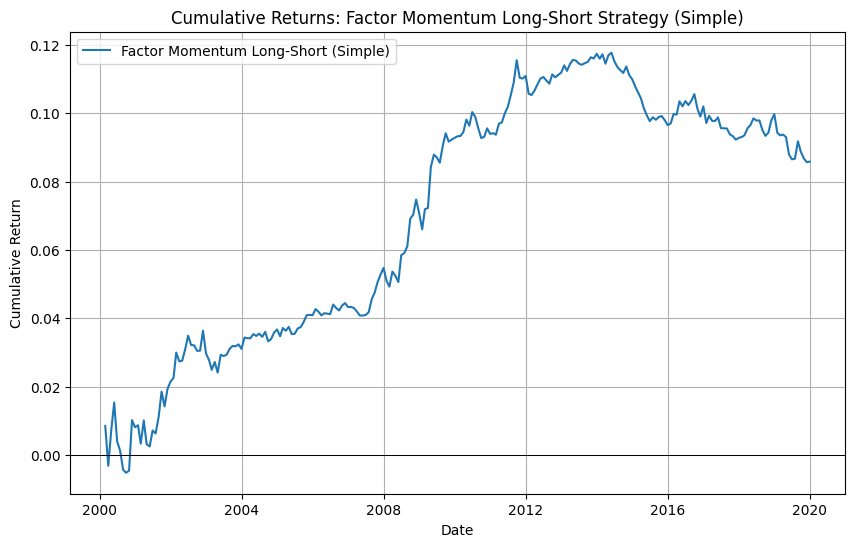

In [206]:
import matplotlib.pyplot as plt

def plot_factor_perf(strat_cum, name = "No name"):
    plt.figure(figsize=(10,6))
    plt.plot(strat_cum.index, strat_cum.values, label=f'Factor Momentum Long-Short ({name})')
    plt.axhline(0, color='black', linewidth=0.7)
    plt.title(f"Cumulative Returns: Factor Momentum Long-Short Strategy ({name})")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_factor_perf(simple_strategy_cum, name = "Simple")

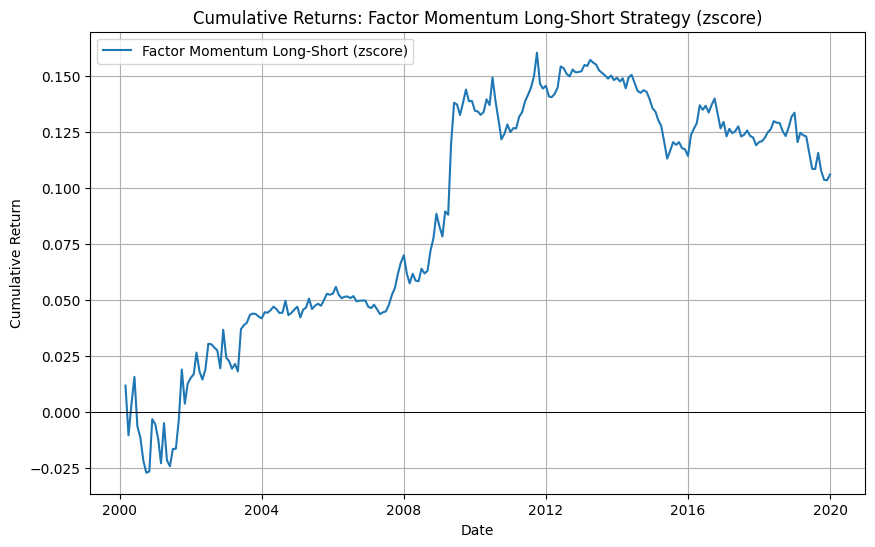

In [207]:
plot_factor_perf(zscore_strategy_cum, name = "zscore")

In [208]:
##########################################
# Load in factor data
##########################################

columns = [
    'date',
    'barrid',
    'ticker',
    'price',
    'return',
]

data = sf_quant.data.load_assets(
    start=start,
    end=end,
    in_universe=True,
    columns=columns
)
data

date,barrid,ticker,price,return
date,str,str,f64,f64
2013-07-31,"""USA06Z1""","""MDXG""",6.26,-0.1595
2013-08-01,"""USA06Z1""","""MDXG""",6.32,0.9585
2013-08-02,"""USA06Z1""","""MDXG""",6.31,-0.1582
2013-08-05,"""USA06Z1""","""MDXG""",6.45,2.2187
2013-08-06,"""USA06Z1""","""MDXG""",6.29,-2.4806
…,…,…,…,…
2019-12-24,"""USBEWM1""","""BXRX""",6.7,-3.1792
2019-12-26,"""USBEWM1""","""BXRX""",7.2,7.4627
2019-12-27,"""USBEWM1""","""BXRX""",7.24,0.5556


In [209]:
##########################################
# Convert to pandas and view
##########################################
data = data.to_pandas()
data

,date,barrid,ticker,price,return
0,2013-07-31,USA06Z1,MDXG,6.26,-0.1595
1,2013-08-01,USA06Z1,MDXG,6.32,0.9585
2,2013-08-02,USA06Z1,MDXG,6.31,-0.1582
3,2013-08-05,USA06Z1,MDXG,6.45,2.2187
4,2013-08-06,USA06Z1,MDXG,6.29,-2.4806
...,...,...,...,...,...
14802771,2019-12-24,USBEWM1,BXRX,6.70,-3.1792
14802772,2019-12-26,USBEWM1,BXRX,7.20,7.4627
14802773,2019-12-27,USBEWM1,BXRX,7.24,0.5556
14802774,2019-12-30,USBEWM1,BXRX,6.98,-3.5912


In [210]:
##########################################
# Convert asset data to be monthly
##########################################

# Ensure 'date' is datetime
data['date'] = pd.to_datetime(data['date'])

# Add a month column (month end frequency)
data['month'] = data['date'].dt.to_period('M').dt.to_timestamp('M')

data['ret'] = data['return'] / 100 
# Group by stock (barrid) and month
monthly_assets = (
    data.groupby(['barrid', 'ticker', 'month'])
    .agg({
        'ret': lambda x: (1 + x).prod() - 1,  # compound returns within month
        'price': 'last'                          # last available price in month
    })
    .rename(columns={'ret': 'monthly_return', 'price': 'month_end_price'})
    .reset_index()
)

# Apply a price filter (e.g. exclude penny stocks < $5)
#monthly_assets = monthly_assets[monthly_assets['month_end_price'] >= 5].copy()

monthly_assets.head()

,barrid,ticker,month,monthly_return,month_end_price
0,USA06Z1,MDXG,2013-07-31,-0.001595,6.26
1,USA06Z1,MDXG,2013-08-31,-0.014377,6.17
2,USA06Z1,MDXG,2013-09-30,-0.324148,4.17
3,USA06Z1,MDXG,2013-10-31,0.270982,5.30
4,USA06Z1,MDXG,2013-11-30,0.188682,6.30


In [211]:
##########################################
# Display list of factors i loaded in
##########################################

factors_list = monthly.columns.to_list()
factors_list

['USSLOWL_BETA',
 'USSLOWL_DIVYILD',
 'USSLOWL_EARNQLTY',
 'USSLOWL_EARNYILD',
 'USSLOWL_GROWTH',
 'USSLOWL_LEVERAGE',
 'USSLOWL_LIQUIDTY',
 'USSLOWL_LTREVRSL',
 'USSLOWL_MGMTQLTY',
 'USSLOWL_MIDCAP',
 'USSLOWL_MOMENTUM',
 'USSLOWL_PROFIT',
 'USSLOWL_PROSPECT',
 'USSLOWL_RESVOL',
 'USSLOWL_SIZE',
 'USSLOWL_VALUE']

In [212]:
##########################################
# Load in beta exposures with the factors we have 
##########################################

# Always include date + barrid
columns = ["date", "barrid"] + factors_list

# Load exposures
betas = sf_quant.data.load_exposures(
    start=start,
    end=end,
    in_universe=True,
    columns=columns
)

# Convert to pandas
betas_pd = betas.to_pandas()
betas_pd['date'] = pd.to_datetime(betas_pd['date'])


In [213]:
# Sanity check
print("monthly_assets keys:", monthly_assets.columns.tolist()[:10])
print("betas_pd keys:", betas_pd.columns.tolist()[:10])
print("simple signals keys:", simple_signals.columns.tolist()[:10])
print("zscore signals keys:", weighted_signals.columns.tolist()[:10])


monthly_assets keys: ['barrid', 'ticker', 'month', 'monthly_return', 'month_end_price']
betas_pd keys: ['date', 'barrid', 'USSLOWL_BETA', 'USSLOWL_DIVYILD', 'USSLOWL_EARNQLTY', 'USSLOWL_EARNYILD', 'USSLOWL_GROWTH', 'USSLOWL_LEVERAGE', 'USSLOWL_LIQUIDTY', 'USSLOWL_LTREVRSL']
simple signals keys: ['USSLOWL_BETA', 'USSLOWL_DIVYILD', 'USSLOWL_EARNQLTY', 'USSLOWL_EARNYILD', 'USSLOWL_GROWTH', 'USSLOWL_LEVERAGE', 'USSLOWL_LIQUIDTY', 'USSLOWL_LTREVRSL', 'USSLOWL_MGMTQLTY', 'USSLOWL_MIDCAP']
zscore signals keys: ['USSLOWL_BETA', 'USSLOWL_DIVYILD', 'USSLOWL_EARNQLTY', 'USSLOWL_EARNYILD', 'USSLOWL_GROWTH', 'USSLOWL_LEVERAGE', 'USSLOWL_LIQUIDTY', 'USSLOWL_LTREVRSL', 'USSLOWL_MGMTQLTY', 'USSLOWL_MIDCAP']


In [214]:
##########################################
# Clean up signals data frame
##########################################
def clean_signals(sgnl):
    # Get rid of the index
    sgnl = sgnl.reset_index().rename(columns={'month_end': 'month'})

    # Drop unnecessary columns
    sgnl = sgnl.drop(columns=['factor', 'index'], errors='ignore')

    # Ensure month is datetime
    sgnl['month'] = pd.to_datetime(sgnl['month'])

    # Reorder: put 'month' first
    cols = ['month'] + [c for c in sgnl.columns if c != 'month']
    sgnl = sgnl[cols]
    return sgnl

simple_signals = clean_signals(simple_signals)
weighted_signals = clean_signals(weighted_signals)



In [215]:
###################################
#  clean betas data frame:
###################################

# Ensure datetime
betas_pd['date'] = pd.to_datetime(betas_pd['date'])

# Add a month column aligned to month end
betas_pd['month'] = betas_pd['date'].dt.to_period('M').dt.to_timestamp('M')

# Group to get month-end betas
# (if multiple betas per month, keep the LAST available one in the month)
betas_monthly = (
    betas_pd
    .sort_values(['barrid', 'date'])
    .groupby(['barrid', 'month'])
    .tail(1)  # last obs in each month
)

# Drop the original daily date
betas_monthly = betas_monthly.drop(columns=['date']).reset_index(drop=True)

beta_cols = ['month'] + [c for c in betas_monthly.columns if c != 'month']
betas_monthly = betas_monthly[beta_cols]

betas_monthly.head()


,month,barrid,USSLOWL_BETA,USSLOWL_DIVYILD,USSLOWL_EARNQLTY,USSLOWL_EARNYILD,USSLOWL_GROWTH,USSLOWL_LEVERAGE,USSLOWL_LIQUIDTY,USSLOWL_LTREVRSL,USSLOWL_MGMTQLTY,USSLOWL_MIDCAP,USSLOWL_MOMENTUM,USSLOWL_PROFIT,USSLOWL_PROSPECT,USSLOWL_RESVOL,USSLOWL_SIZE,USSLOWL_VALUE
0,2013-07-31,USA06Z1,-2.291,-1.221,-2.280,-1.675,1.501,-0.863,-2.296,0.033,-1.798,-0.893,2.660,1.411,-0.461,2.771,-2.746,-1.229
1,2013-08-31,USA06Z1,-0.991,-1.226,-2.928,-1.626,1.466,-0.861,-2.166,-0.299,-1.771,-0.841,2.394,1.415,-0.456,2.763,-2.723,-1.238
2,2013-09-30,USA06Z1,-1.788,-1.186,-2.933,-1.681,1.457,-0.844,-2.131,-0.644,-1.754,-1.845,2.333,1.420,-0.012,2.777,-3.025,-1.132
3,2013-10-31,USA06Z1,-0.356,-1.205,-2.913,-1.518,1.469,-0.859,-2.054,-0.517,-1.753,-1.274,0.259,1.426,-0.007,2.787,-2.865,-1.184
4,2013-11-30,USA06Z1,-0.384,-1.200,-2.878,-1.526,1.416,-0.866,-2.046,-0.179,-1.756,-1.037,0.858,1.452,-0.017,2.827,-2.802,-1.198


In [216]:
###################################
# Clean monthly assets
###################################

# monthly_assets should already be at month-end
# Double-check
monthly_assets['month'] = pd.to_datetime(monthly_assets['month'])
monthly_assets = monthly_assets[['barrid', 'ticker', 'month', 'monthly_return', 'month_end_price']]

monthly_assets.head()


,barrid,ticker,month,monthly_return,month_end_price
0,USA06Z1,MDXG,2013-07-31,-0.001595,6.26
1,USA06Z1,MDXG,2013-08-31,-0.014377,6.17
2,USA06Z1,MDXG,2013-09-30,-0.324148,4.17
3,USA06Z1,MDXG,2013-10-31,0.270982,5.30
4,USA06Z1,MDXG,2013-11-30,0.188682,6.30


In [217]:
###################################
# Align number of factors - Our signals data set has a couple of factors that the betas df doesn't have
###################################

def align_factors(bts_monthly, sgnl):

    factors_expo = set(bts_monthly.columns) - {'barrid', 'month'}
    factors_signals = set(sgnl.columns) - {'month'}

    common_factors = sorted(factors_expo & factors_signals)

    print("Common factors:", common_factors)
    print("In signals only:", sorted(factors_signals - factors_expo))
    print("In exposures only:", sorted(factors_expo - factors_signals))

    # Reduce to only common
    betas_aligned = bts_monthly[['barrid', 'month'] + common_factors].copy()
    signals_aligned = sgnl[['month'] + common_factors].copy()
    return betas_aligned, signals_aligned

betas_aligned, simple_signals_aligned = align_factors(betas_monthly, simple_signals)
betas_aligned, weighted_signals_aligned = align_factors(betas_monthly, weighted_signals)


Common factors: ['USSLOWL_BETA', 'USSLOWL_DIVYILD', 'USSLOWL_EARNQLTY', 'USSLOWL_EARNYILD', 'USSLOWL_GROWTH', 'USSLOWL_LEVERAGE', 'USSLOWL_LIQUIDTY', 'USSLOWL_LTREVRSL', 'USSLOWL_MGMTQLTY', 'USSLOWL_MIDCAP', 'USSLOWL_MOMENTUM', 'USSLOWL_PROFIT', 'USSLOWL_PROSPECT', 'USSLOWL_RESVOL', 'USSLOWL_SIZE', 'USSLOWL_VALUE']
In signals only: []
In exposures only: []
Common factors: ['USSLOWL_BETA', 'USSLOWL_DIVYILD', 'USSLOWL_EARNQLTY', 'USSLOWL_EARNYILD', 'USSLOWL_GROWTH', 'USSLOWL_LEVERAGE', 'USSLOWL_LIQUIDTY', 'USSLOWL_LTREVRSL', 'USSLOWL_MGMTQLTY', 'USSLOWL_MIDCAP', 'USSLOWL_MOMENTUM', 'USSLOWL_PROFIT', 'USSLOWL_PROSPECT', 'USSLOWL_RESVOL', 'USSLOWL_SIZE', 'USSLOWL_VALUE']
In signals only: []
In exposures only: []


In [218]:
# Sanity check
print("monthly_assets:", monthly_assets.shape, monthly_assets.columns.tolist())
print("betas_aligned:", betas_aligned.shape, betas_aligned.columns.tolist())
print("simple signals_aligned:", simple_signals_aligned.shape, simple_signals_aligned.columns.tolist())
print("weighted signals_aligned:", weighted_signals_aligned.shape, weighted_signals_aligned.columns.tolist())

print("Assets date range:", monthly_assets['month'].min(), "→", monthly_assets['month'].max())
print("Betas date range:", betas_aligned['month'].min(), "→", betas_aligned['month'].max())
print("Signals date range:", simple_signals_aligned['month'].min(), "→", simple_signals_aligned['month'].max())
print("weighted date range:", weighted_signals_aligned['month'].min(), "→", weighted_signals_aligned['month'].max())


monthly_assets: (715383, 5) ['barrid', 'ticker', 'month', 'monthly_return', 'month_end_price']
betas_aligned: (714090, 18) ['barrid', 'month', 'USSLOWL_BETA', 'USSLOWL_DIVYILD', 'USSLOWL_EARNQLTY', 'USSLOWL_EARNYILD', 'USSLOWL_GROWTH', 'USSLOWL_LEVERAGE', 'USSLOWL_LIQUIDTY', 'USSLOWL_LTREVRSL', 'USSLOWL_MGMTQLTY', 'USSLOWL_MIDCAP', 'USSLOWL_MOMENTUM', 'USSLOWL_PROFIT', 'USSLOWL_PROSPECT', 'USSLOWL_RESVOL', 'USSLOWL_SIZE', 'USSLOWL_VALUE']
simple signals_aligned: (240, 17) ['month', 'USSLOWL_BETA', 'USSLOWL_DIVYILD', 'USSLOWL_EARNQLTY', 'USSLOWL_EARNYILD', 'USSLOWL_GROWTH', 'USSLOWL_LEVERAGE', 'USSLOWL_LIQUIDTY', 'USSLOWL_LTREVRSL', 'USSLOWL_MGMTQLTY', 'USSLOWL_MIDCAP', 'USSLOWL_MOMENTUM', 'USSLOWL_PROFIT', 'USSLOWL_PROSPECT', 'USSLOWL_RESVOL', 'USSLOWL_SIZE', 'USSLOWL_VALUE']
weighted signals_aligned: (240, 17) ['month', 'USSLOWL_BETA', 'USSLOWL_DIVYILD', 'USSLOWL_EARNQLTY', 'USSLOWL_EARNYILD', 'USSLOWL_GROWTH', 'USSLOWL_LEVERAGE', 'USSLOWL_LIQUIDTY', 'USSLOWL_LTREVRSL', 'USSLOWL_MGMTQ

In [219]:
##################################
# make sure everything's sorted right and rename:
##################################
monthly_assets = monthly_assets.sort_values(['month', 'barrid']).reset_index(drop=True)
betas_aligned = betas_aligned.sort_values(['month', 'barrid']).reset_index(drop=True)
simple_signals_aligned = simple_signals_aligned.sort_values('month').reset_index(drop=True)
weighted_aligned = weighted_signals_aligned.sort_values('month').reset_index(drop=True)

assets = monthly_assets.copy()
betas = betas_aligned.copy()
simple_signals = simple_signals_aligned.copy()
weighted_signals = weighted_signals_aligned.copy()



In [220]:
############################
# Prep for merging. Not totally sure why this is necessary
############################

assets = assets.sort_values(['month', 'barrid']).reset_index(drop=True)
betas = betas.sort_values(['month', 'barrid']).reset_index(drop=True)
simple_signals = simple_signals.sort_values('month').reset_index(drop=True)
weighted_signals = weighted_signals.sort_values('month').reset_index(drop=True)



In [221]:
####################################
# Merge all three data sets together
####################################

# Merge assets with betas first
df_assets_beta = assets.merge(betas, on=['month', 'barrid'], how='inner')

# Merge in signals (on month only)
df_all_simple = df_assets_beta.merge(simple_signals, on='month', how='inner', suffixes=('_beta', '_signal'))
df_all_weighted = df_assets_beta.merge(weighted_signals, on='month', how='inner', suffixes=('_beta', '_signal'))



In [222]:
############################
# Create stock level signals
############################

# 1. Identify factor columns
factor_cols = [
    'USSLOWL_BETA',
    'USSLOWL_DIVYILD',
    'USSLOWL_EARNQLTY',
    'USSLOWL_EARNYILD',
    'USSLOWL_GROWTH',
    'USSLOWL_LEVERAGE',
    'USSLOWL_LIQUIDTY',
    'USSLOWL_LTREVRSL',
    'USSLOWL_MGMTQLTY',
    'USSLOWL_MIDCAP',
    'USSLOWL_MOMENTUM',
    'USSLOWL_PROFIT',
    'USSLOWL_PROSPECT',
    'USSLOWL_RESVOL',
    'USSLOWL_SIZE',
    'USSLOWL_VALUE'
]

# Exposures (from betas)
exposure_cols = [f"{c}_beta" for c in factor_cols]

# Signals (from signals)
signal_cols = [f"{c}_signal" for c in factor_cols]

def create_stock_signal(dataframe, name = "signal_type"):

# 2. Compute stock-level signal as row-wise dot product of exposures and signals
#df['stock_signal'] = df[exposure_cols].to_numpy() @ df[signal_cols].to_numpy().T.diagonal()

    # Alternative using row-wise sum of products (sometimes clearer)
    dataframe[f'stock_signal_{name}'] = (dataframe[exposure_cols].values * dataframe[signal_cols].values).sum(axis=1)

    # 3. Sanity check
    dataframe[f'stock_signal_{name}'].describe()

    return dataframe

df_simple = create_stock_signal(df_all_simple, name = "simple")
df_weighted = create_stock_signal(df_all_weighted, name = "zscore")


In [223]:
###################################
# Filter out low-priced stocks
###################################

def price_filter(df):
    df = df[df['month_end_price'] >= 5].copy()
    return df

df_simple = price_filter(df_simple)
df_weighted = price_filter(df_weighted)



In [224]:
##################################
# Define the position we're taking for each stock based on its signal
##################################
def compute_returns(df, name = "signal_type"):
    
    df['position'] = 0  # default 0
    df.loc[df[f'stock_signal_{name}'] > 0, 'position'] = 1
    df.loc[df[f'stock_signal_{name}'] < 0, 'position'] = -1

    # Compute the strategy return for each stock
    df[f'strategy_return_{name}'] = df['position'] * df['monthly_return']

    # Aggregate to get an equal-weighted portfolio return per month
    portfolio_returns = (
        df.groupby('month')[f'strategy_return_{name}']
        .mean()
        .to_frame()
        .rename(columns={f'strategy_return_{name}': f'portfolio_return_{name}'})
    )

    # Compute cumulative returns
    portfolio_returns[f'cumulative_return_{name}'] = (1 + portfolio_returns[f'portfolio_return_{name}']).cumprod()
    

    return portfolio_returns

simple_portfolio_returns = compute_returns(df_simple, name = 'simple')
weighted_portfolio_returns = compute_returns(df_weighted, name = 'zscore')

In [225]:
###################
# Basic metrics
###################
def view_metrics(returns, name = "signal_type"):
    mean_monthly = returns[f'portfolio_return_{name}'].mean()
    vol_monthly = returns[f'portfolio_return_{name}'].std()
    sharpe = mean_monthly / vol_monthly * (12**0.5)  # Annualized Sharpe

    print(f"Mean monthly return {name}:", mean_monthly)
    print(f"Monthly volatility {name}:", vol_monthly)
    print(f"Annualized Sharpe {name}:", sharpe)

view_metrics(simple_portfolio_returns, name = 'simple')
view_metrics(weighted_portfolio_returns, name = 'zscore')


Mean monthly return simple: 0.0006423542271087435
Monthly volatility simple: 0.028496421067055543
Annualized Sharpe simple: 0.07808630811503811
Mean monthly return zscore: 0.0005652156769530502
Monthly volatility zscore: 0.03138504722416084
Annualized Sharpe zscore: 0.0623852666350924


In [226]:
import matplotlib.pyplot as plt

def visualize_returns(returns, name = 'signal_type'):
    plt.figure(figsize=(10, 5))
    plt.plot(returns.index, returns[f'cumulative_return_{name}'], label='Strategy')
    plt.title(f"Cumulative Returns {name}")
    plt.xlabel("Month")
    plt.ylabel(f"Cumulative Return {name}")
    plt.legend()
    plt.grid(True)
    plt.show()


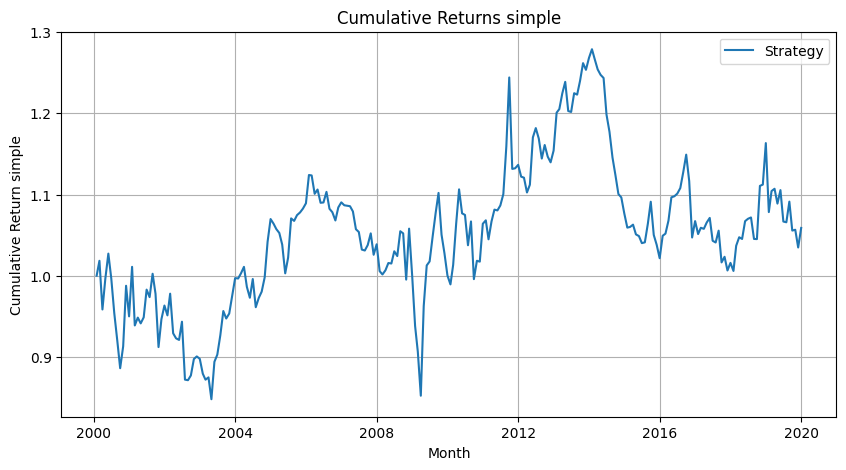

In [227]:
visualize_returns(simple_portfolio_returns, name = 'simple')

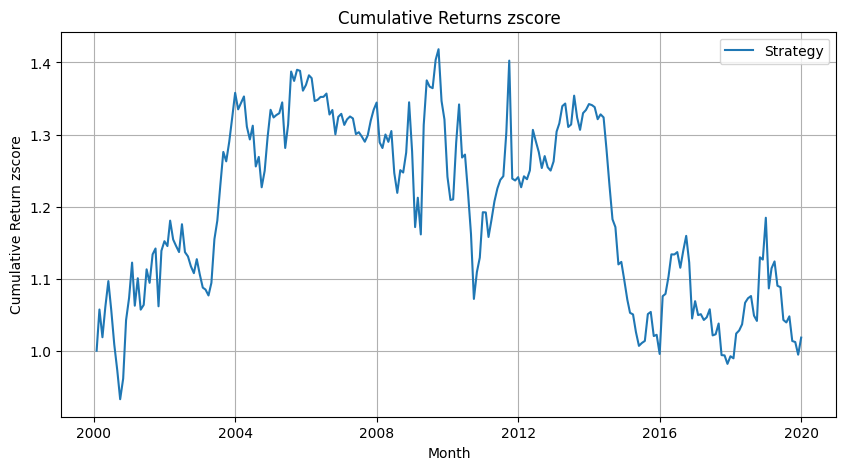

In [228]:
visualize_returns(weighted_portfolio_returns, name = 'zscore')

In [ ]:
# #######################
# # Long short performance visualizations
# #######################

# def longshort_visualization(df, name = 'signal_type'):
#     # Long positions: stock_signal > 0
#     long_returns = df[df['position'] > 0].groupby('month')[f'strategy_return_{name}'].mean()

#     # Short positions: stock_signal < 0
#     short_returns = df[df['position'] < 0].groupby('month')[f'strategy_return_{name}'].mean()

#     long_cum = (1 + long_returns).cumprod()
#     short_cum = (1 + short_returns).cumprod()

#     plt.figure(figsize=(10, 5))
#     plt.plot(long_cum.index, long_cum, label=f'Long Portfolio', color='green')
#     plt.plot(short_cum.index, short_cum, label='Short Portfolio', color='red')
#     plt.title(f"Cumulative Returns: Long vs Short Portfolio ({name})")
#     plt.xlabel("Month")
#     plt.ylabel("Cumulative Return")
#     plt.legend()
#     plt.grid(True)
#     plt.show()

#     def performance_metrics(returns):
#         mean = returns.mean()
#         vol = returns.std()
#         sharpe = mean / vol * (12**0.5)
#         print(f"{mean}, {vol}, {sharpe}")

#     performance_metrics(long_returns)
#     performance_metrics(short_returns)


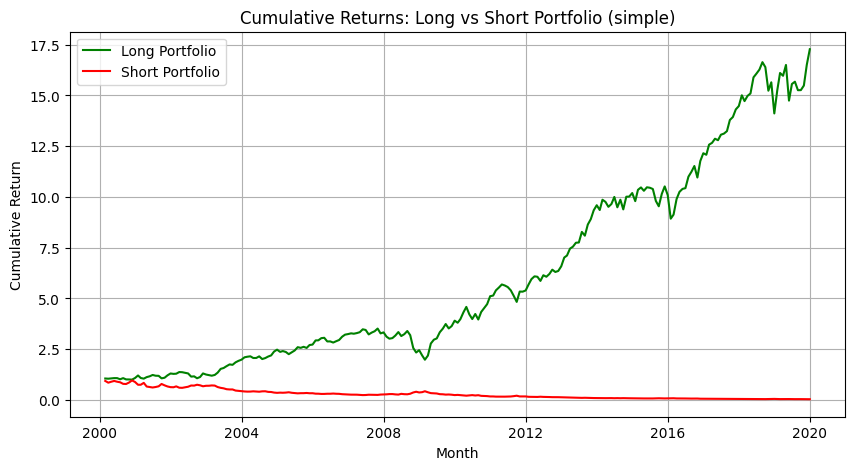

0.013343071590621054, 0.05220321235223606, 0.8854197618355805
-0.01187364870286982, 0.05649780477596504, -0.7280198905478107


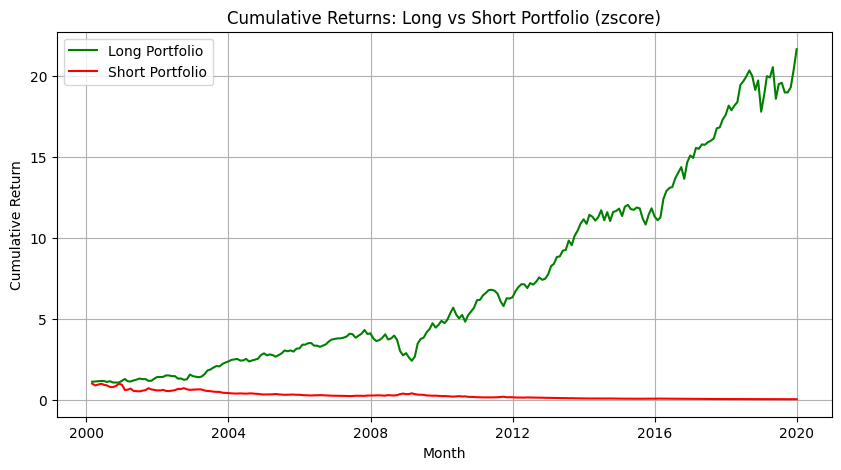

0.014279563821080508, 0.05237203829093779, 0.94450897292319
-0.011971713945810694, 0.06166379277977371, -0.6725378337294385
